# IRC Behavioral Analysis - Visualization

### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

## Loading Data

In [2]:
import os


log_names_mal = ['03','04','34','39','42','51','56','62']
log_names_benign = ['irc1']
log_names = log_names_mal + log_names_benign

# project_dir = '/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/' 
project_dir = '/home/prenek/IRC-Behavioral-Analysis/'

log_dir = os.path.join(project_dir, 'zeek/logs/')
out_dir = os.path.join(project_dir, 'python/out/')
plot_dir = os.path.join(project_dir, 'python/plots/')

fn_join_freq = 'join_freq.log'
fn_lev_dist = 'lev_dist.log'

logs_fn_join = [os.path.join(out_dir,l, fn_join_freq) for l in log_names]
logs_fn_join_mal = [os.path.join(out_dir,l, fn_join_freq) for l in log_names_mal]
logs_fn_join_benign = [os.path.join(out_dir,l, fn_join_freq) for l in log_names_benign]

logs_fn_privmsg = [os.path.join(out_dir,l, fn_lev_dist) for l in log_names]
logs_fn_privmsg_mal = [os.path.join(out_dir,l,fn_lev_dist) for l in log_names_mal]
logs_fn_privmsg_benign = [os.path.join(out_dir,l, fn_lev_dist) for l in log_names_benign]

## Number of Users in Channel per Day

### Data Import

In [ ]:
## JOIN LOGS
df_join_mal = None
df_tmp = None
for pcap, log in zip(log_names_mal, logs_fn_join_mal):
    df_tmp = pd.read_csv(log, sep=';', encoding='utf-8')
    df_tmp['pcap'] = pcap
    df_tmp['malicious'] = 1
    df_join_mal = pd.concat([df_join_mal, df_tmp], ignore_index=True, sort=True)
    df_join_mal.drop(["Unnamed: 0"], axis=1, inplace=True)

df_join_benign = None
df_tmp = None
for pcap, log in zip(log_names_benign, logs_fn_join_benign):
    print(log)
    df_tmp = pd.read_csv(log, sep=';', encoding='utf-8')
    df_tmp['pcap'] = pcap
    df_tmp['malicious'] = 0
    df_join_benign = pd.concat([df_join_benign, df_tmp], ignore_index=True, sort=True)
    df_join_benign.drop(["Unnamed: 0"], axis=1, inplace=True)

df_join = pd.concat([df_join_mal, df_join_benign], ignore_index=True)
df_join.head()

In [ ]:
def ircjoin_visualize(df, log, channel):
    plt.bar(df['date'], df['users_count'])
    plt.title('pcap {}, channel {}'.format(log,channel))
    plt.xlabel('dates')
    plt.ylabel('users')
    plt.show()

for l in log_names:
    df_join_tmp = df_join[df_join['pcap'] == l]
    for channel,df in df_join_tmp.groupby('channel'):
        ircjoin_visualize(df,l,channel)

## Levenshtein Distance of Messages in Channel

### Data Import 

In [4]:
# # PRIVMSG LOGS
# df_privmsg_mal = None
# df_tmp = None
# for pcap, log in zip(log_names_mal, logs_fn_privmsg_mal):
#     df_tmp = pd.read_csv(log, sep=';', encoding='utf-8')
#     df_tmp['pcap'] = pcap
#     df_tmp['malicious'] = 1
#     df_privmsg_mal = pd.concat([df_privmsg_mal, df_tmp], ignore_index=True, sort=True)
#     df_privmsg_mal.drop(["Unnamed: 0"], axis=1, inplace=True)

# import ast
# df_privmsg_mal['lev_dist'] =  df_privmsg_mal['lev_dist'].apply(lambda x: ast.literal_eval(x))
# df_privmsg_mal.head()


import ast
fn = os.path.join(out_dir, 'lev_dist_mal.csv')
df_privmsg_mal = pd.read_csv(fn, converters={'lev_dist': ast.literal_eval})
df_privmsg_mal.drop(["Unnamed: 0"], axis=1, inplace=True)
df_privmsg_mal.head()

,channel,lev_dist,malicious,num_sources,pcap
0,##Summit,"[9, 40, 39, 40, 38, 63, 37, 34, 40, 35, 35, 28...",1,6.0,34
1,#Runz,[],1,1.0,42
2,#007,"[28, 28, 62, 27, 33, 28, 62, 7, 7, 25, 28, 28,...",1,3.0,51
3,#all,"[23, 20, 44, 46, 40, 42, 37, 42, 41, 40, 31, 3...",1,4.0,51
4,#kz,"[28, 0, 0, 0, 23, 44, 46, 40, 42, 37, 42, 41, ...",1,2.0,51


In [ ]:
# fn = os.path.join(out_dir, 'lev_dist_mal.csv')
# df_privmsg_mal.to_csv(fn)
# df_privmsg_mal['lev_dist'][0][:19]

In [5]:
del df_privmsg_mal

In [ ]:
df_privmsg_mal['lev_dist_mean'] = df_privmsg_mal['lev_dist'].apply(lambda x: np.mean(x))
df_privmsg_mal['lev_dist_std'] = df_privmsg_mal['lev_dist'].apply(lambda x: np.std(x))
df_privmsg_mal.head()

### Bubble plot

In [ ]:
def ircprivmgs_visualize(lev_dist_arr,num_sources_arr, num_messages_arr):
    cm = plt.cm.get_cmap('jet')
    x = np.array(num_sources_arr)
    y = np.array(num_messages_arr)
    z = 5*np.power(np.array(lev_dist_arr),2)
    
    fig, ax = plt.subplots()
    sc = ax.scatter(x,y,s=z,c=z,cmap=cm, alpha=0.4)
    ax.grid(alpha=0.5)
    fig.colorbar(sc)
    plt.xlabel('Number of Users in Channel')
    plt.ylabel('Number of Messages')
    plt.title('Levenstein Distance of Messages per Capture')
    plt.show()


df_privmsg_mal_notna = df_privmsg_mal[df_privmsg_mal['lev_dist_mean'].notna()]
colors = []
for pcap in df_privmsg_mal_notna.pcap.unique():
    df_tmp = df_privmsg_mal_notna[df_privmsg_mal_notna['pcap'] == pcap]
    ircprivmgs_visualize(df_tmp['lev_dist_mean'], df_tmp['num_sources'], [-1] * df_tmp.shape[0])
    


# for l in log_names:
# for log_name,l in zip(log_names,logs_privmsg):
#     for ll in l:
#         channel, lev_dists_pairwise = ll
#         lev_dist_arr.append(np.mean(lev_dists_pairwise))
#         num_messages_arr.append(len(lev_dists_pairwise))
#         num_sources_arr.append(np.random.randint(10))

# ircprivmgs_visualize(lev_dist_arr, num_sources_arr, num_messages_arr)

## Distribution plot

### Malicious samples

In [ ]:
df_privmsg_mal.describe()

In [ ]:
fig = plt.figure()
for i, df_el in df_privmsg_mal.iterrows():
    sns.distplot(df_el['lev_dist'])
    plt.title('Malicious PRIVMSG - Distribution plot of pairwise distance')
    plt.xlabel('Levenshtein distance')
    plt.ylabel('Distribution')
legend_titles = list(map(lambda x: ": ".join(x), list(zip(df_privmsg_mal['pcap'], df_privmsg_mal['channel']))))   
fig.legend(legend_titles)
plt.savefig(os.path.join(plot_dir,'privmsg_distplot_all.pdf'), format='pdf')

95 quantile

In [ ]:
from scipy import stats

stats.describe(df_privmsg_mal[df_privmsg_mal['pcap'] == '56']['lev_dist'].iloc[0])

In [ ]:
fig = plt.figure()
for i, df_el in df_privmsg_mal.iterrows():
    if df_el['pcap'] == '56': 
        continue
    sns.distplot(df_el['lev_dist'])
    plt.title('Malicious PRIVMSG - Distribution plot of pairwise distance')
    plt.xlabel('Levenshtein distance')
    plt.ylabel('Distribution')

legend_titles = list(map(lambda x: ": ".join(x), list(zip(df_privmsg_mal['pcap'], df_privmsg_mal['channel']))))   
fig.legend(legend_titles)
plt.savefig(os.path.join(plot_dir, 'privmsg_distplot_no56.pdf'), format='pdf')

### Benign Samples

/home/prenek/IRC-Behavioral-Analysis/python/venv/lib/python3.6/site-packages/seaborn/distributions.py:200: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/prenek/IRC-Behavioral-Analysis/python/venv/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/prenek/IRC-Behavioral-Analysis/python/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/prenek/IRC-Behavioral-Analysis/python/venv/lib/python3.6/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/prenek/IRC-Behavioral-Analysis/python/venv/lib/python3.6/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarn

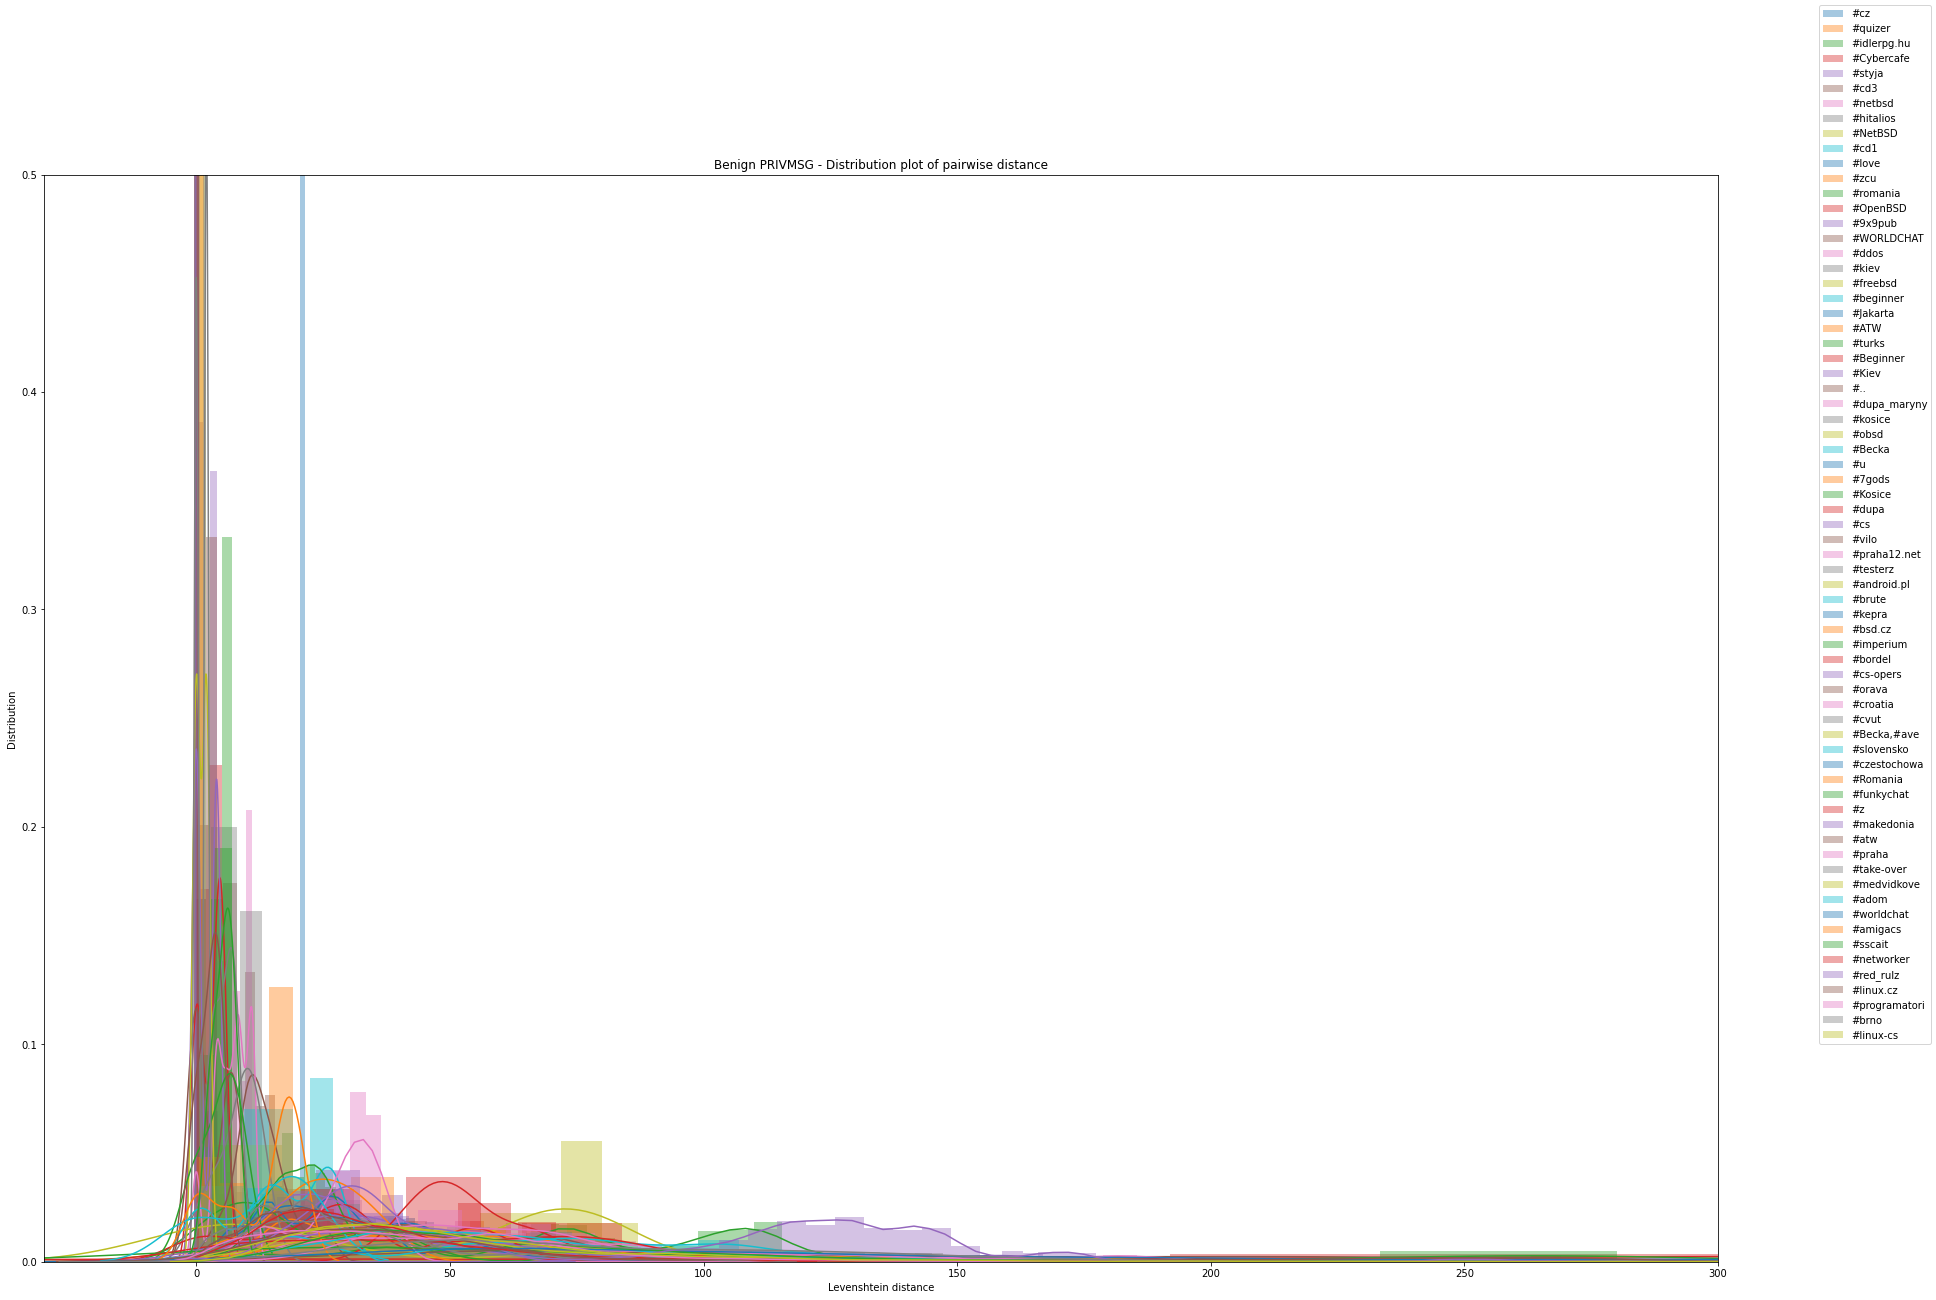

In [9]:
import ast
# FIXME: read csv in chunks because the log is too big
df_privmsg_benign = None
chunksize = 10 ** 3
# df_tmp = None
channels = []
fig = plt.figure(figsize=(30,20))
plt.title('Benign PRIVMSG - Distribution plot of pairwise distance')
plt.xlabel('Levenshtein distance')
plt.ylabel('Distribution')
plt.ylim((0,0.5))
plt.xlim((-30,300))
for pcap, log in zip(log_names_benign, logs_fn_privmsg_benign):
    # read line by line
    for i, df_el in enumerate(pd.read_csv(log, chunksize=1)):
        try:
            channels.append(df_el['channel'].iloc[0])
            el = np.array(ast.literal_eval(df_el['lev_dist'].iloc[0]))
            sns.distplot(np.absolute(el))
        except:
            del el
            continue

    fig.legend(channels)    
    plt.savefig(os.path.join(plot_dir,'benign_privmsg_distplot.pdf'), format='pdf')

In [ ]:
for d in dists:
    sns.distplot(d)




[]

In [ ]:
df_privmsg_benign.reset_index(drop=True, inplace=True)
df_privmsg_benign.index

In [ ]:
fig = plt.figure()

for i, df_el in df_privmsg_benign.iterrows():
    sns.distplot(df_el['lev_dist'])
    plt.title('Benign PRIVMSG - Distribution plot of pairwise distance')
    plt.xlabel('Levenshtein distance')
    plt.ylabel('Distribution')
legend_titles = list(map(lambda x: ": ".join(x), list(zip(df_privmsg_benign['pcap'], df_privmsg_benign['channel']))))   
fig.legend(legend_titles)
plt.savefig(os.path.join(plot_dir,'benign_privmsg_distplot_all.pdf'), format='pdf')